#### **This notebook gets the topic of campaign**

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os
import re

import importlib

#### packages
import helper.strategy_helper as st_hp
import helper.visualization as vz_hp
import config.config as config_hp
import helper.pandas_helper as pd_hp
import helper.clean_tweet as cp_hp

[nltk_data] Downloading package stopwords to
[nltk_data]     /N/u/potem/Quartz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **Manual inspection**

In [2]:
config = config_hp.config()
topic_model = config['TOPIC_MODEL']
egypt_org_tweets = topic_model['egypt_org_tweets']

df_egypt_tweets = pd.read_pickle(egypt_org_tweets)

In [3]:
df_egypt_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2415 entries, 0 to 2414
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweetid         2415 non-null   int64 
 1   text            2415 non-null   object
 2   lang            2415 non-null   object
 3   author_id       2415 non-null   object
 4   poster_tweetid  2415 non-null   int64 
 5   campaign        2415 non-null   object
 6   id              2415 non-null   object
 7   annotation      2415 non-null   object
 8   hashtags        2415 non-null   object
 9   count           2415 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 207.5+ KB


#### **Convert into docx**

In [39]:
from docx import Document

doc = Document()

df = df_egypt_tweets[['tweetid', 'text']]

# Add a Title to the Document
# doc.add_heading('DataFrame Column to DOCX', 0)

# Iterate through DataFrame's column and write to DOCX
for index, row in df.iterrows():
    text = row['text']
    tweetid = row['tweetid']
    doc.add_paragraph(f'[{tweetid} *** {text}]')

# Save the Document
doc.save('egypt_docx.docx')

In [5]:
df_egypt_tweets[['tweetid', 'text']].to_csv('egypt_poster_tweets.txt',
                                            sep='\t',
                                            index=False)

#### **Convert docx into dataframe**

In [33]:
set(df_egypt_tweets['text'].isnull())

{False}

In [44]:
len(df_egypt_tweets)

2415

In [51]:
from docx import Document
import ast

doc = Document("egypt_english.docx")
open_brac = '['
closing_brac = ']'

all_element = []
print(len(doc.paragraphs))
for p in doc.paragraphs:
    if p.text.strip() != "":
        element_list = (p.text).split('***')
        
        if len(element_list) == 1:
            continue
            
        element_list[0] = element_list[0].replace(open_brac, "")
        element_list[0] = element_list[0].replace(' ', "")
        element_list[1] = element_list[1].replace(closing_brac, "")
        
        if len(element_list) > 2:
            list_string = ' '.join(element_list[1:])
            element_list[1]  = list_string.replace('*', "")
            
        all_element.append([element_list[0], element_list[1]])
        

df = pd.DataFrame(all_element, columns=['tweetid', 
                                       "english_text"])
df_egypt_tweets['tweetid'] = df_egypt_tweets['tweetid'].astype(str)

df_merge = df_egypt_tweets.merge(df,
                      on='tweetid'
                     )

df_merge.to_pickle('egypt_translated_poster_tweets.pkl.gz')

2415


#### **Word cloud**

In [53]:
df_merge['hashtags'] = df_merge['english_text'].apply(
        lambda x: list(set(re.findall(r'\B\#(\w+)', x)))
    )
df_merge['count'] = df_merge['hashtags'].apply(
    lambda x: len(x)
)

df_hasht = df_merge.loc[df_merge['count'] != 0]
df_hasht = df_hasht.explode('hashtags')
# print(df_hasht)
df_grp = (df_hasht
          .groupby('hashtags')
          .size()
          .to_frame('freq')
          .reset_index()
          .sort_values(by=['freq'],
                       ascending=False
                      )
         )

print(df_grp.head(10))

              hashtags  freq
482              Saudi   211
525              Sudan   189
20                  Al   176
602                UAE   127
655              Yemen    98
431              Qatar    97
314              Libya    59
149              Egypt    49
340  Mercedes_Elite_Al    47
597             Turkey    46


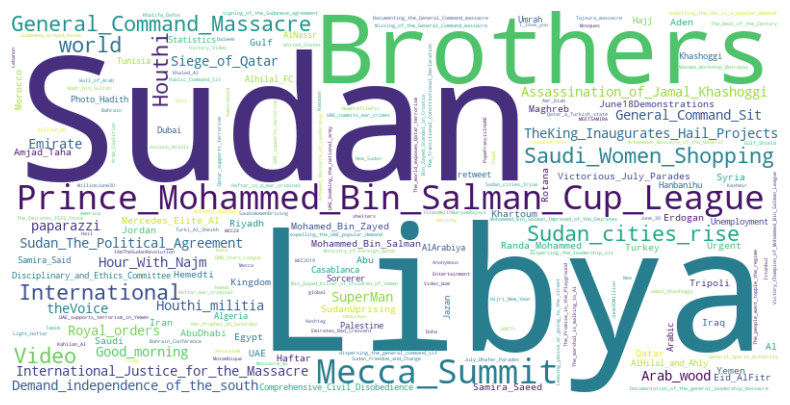

In [63]:
importlib.reload(vz_hp)

vz_hp.word_cloud(df_grp['hashtags'].tolist())

In [56]:
def word_cloud(word_list, filename):
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    text = ' '.join(word_list)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',  # Background color of the word cloud
        colormap='viridis',        # Color map for the word cloud
        # font_path='./KFGQPC Uthmanic Script HAFS Regular.otf',  # Path to a font file (if needed for non-ASCII characters)
    ).generate(text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()
    
    if filename != None:
        wordcloud.to_file(filename)

[nltk_data] Downloading package stopwords to
[nltk_data]     /N/u/potem/Quartz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


416         iran
589       people
691       russia
613    president
558        obama
418      iranian
389        human
785        syria
686       rights
210         deal
Name: filtered_text, dtype: object


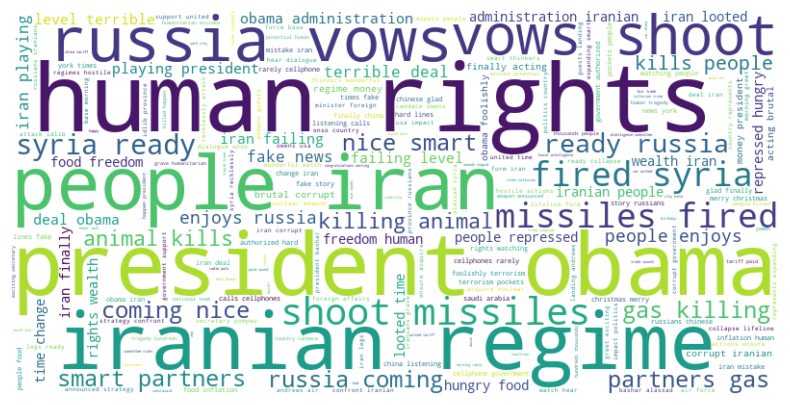

In [64]:
import stopwordsiso
importlib.reload(cp_hp)

lang='en'
def remove_stopwords(lang, df):
    if stopwordsiso.has_lang(lang) != True:
        return

    condition = df['lang'] == lang
    df = df.loc[~df['english_text'].isnull()]
    df = df.loc[df['english_text'] != 0]

    df['tweet_text'] = df['english_text'].apply(
        lambda x: cp_hp.clean_tweet(x)
    )
    
    rm = re.compile(r'\b\w+#')
    rmb = re.compile(r'#\b\w+')


    df = df.loc[~df['tweet_text'].isnull()]

    df = df[df['tweet_text'].str.len()>0]

    df['tweet_text'] = df['tweet_text'].apply(
        lambda x: rm.sub(r'', x)
    )
    
    df['tweet_text_list'] = df['tweet_text'].apply(
        lambda x: x.split()
    )

    df.loc[condition, 'filtered_text'] = \
    df['tweet_text_list'].apply(lambda x:
                                [str(word) for word in x if word not in stopwordsiso.stopwords(lang)]
                               )
    df = df[df['tweet_text_list'].apply(lambda x: len(x)>0)]

    df_exploded = df.explode('filtered_text')
    df_exploded = df_exploded.loc[~(df_exploded['filtered_text'] == 'nan')]
    df_exploded = df_exploded.loc[~(df_exploded['filtered_text'] == '.')]
    df_exploded = df_exploded.loc[~(df_exploded['filtered_text'] == '..')]
    df_exploded = df_exploded.loc[~(df_exploded['filtered_text'] == '-')]

    df_exploded = df_exploded.loc[~df_exploded['filtered_text'].isnull()]

    df_exploded['filtered_text'] = df_exploded['filtered_text'].astype(str)
    

    df_expl_grp = (df_exploded.groupby(['filtered_text'])
              .size()
              .to_frame('count')
              .reset_index()
             )
    df_expl_grp = df_expl_grp.sort_values(by=['count'],
                                          ascending=False)
    
    print(df_expl_grp['filtered_text'].head(10))
    wordlist = df_exploded.loc[
        df_exploded['filtered_text'].isin(df_expl_grp['filtered_text'])
    ]['filtered_text'].tolist()

    return wordlist


wordlist = remove_stopwords(lang, df_merge)
# print(set(wordlist))
word_cloud(wordlist, './plots/wordcloud_egypt_frequent_word.png')